In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.autograd.functional as F
USE_CUDA = torch.cuda.is_available() 
device = torch.device("cuda" if USE_CUDA else "cpu") 
print("device", device)
batch_size = 24
hidden_size = 10
state_size = 1
action_size = 1
reward_size = 1

class Custom_Activation_F:
    
    def __init__(self, rate = 1):
        self.rate = rate
        
    def logact(self, a):
        '''
        logistic activation function
        '''
        i = 0
        while i < len(a):
            j = 0
            while j < len(a[i]):
                if a[i][j] > 0:
                    a[i][j] = torch.log(a[i][j] + self.rate)
                else:
                    a[i][j] = - torch.log(self.rate - a[i][j])
                j = j + 1
            i = i + 1
        return a
 

device cpu


In [2]:
class BayesianLinear(nn.Module):
    
    def __init__(self, i_s, o_s):
        '''
        i_s = input_size
        o_s = output_size
        
        '''
        super().__init__()
        self.i_s = i_s
        self.o_s = o_s
        self.b_s = 1
        self.w = nn.Parameter(
            torch.zeros(self.i_s, self.o_s, dtype = torch.float32, requires_grad=True)
        )
        self.b = nn.Parameter(
            torch.zeros(self.o_s, dtype = torch.float32, requires_grad=True)
        )
        
        self.w_prior = torch.zeros(self.i_s, self.o_s)
        self.b_prior = torch.zeros(self.o_s)
        
    def _rep(self, mu):
        return mu + torch.randn_like(mu)*0.1
    
    def _update_prior(self, w1, w2, b, rate = 0.1):
        self.w_prior = w.clone().detach()*rate + self.w_prior*(1-rate)
        self.b_prior = b.clone().detach()*rate + self.b_prior*(1-rate)
        
    def kldloss(self):
        sum1 = torch.sum(torch.square(self.w - self.w_prior))
        sum2 = torch.sum(torch.square(self.b - self.b_prior))
        return sum1 + sum2
    
    def forward(self, x):
        self.b_s = len(x)
        b = self._rep(self.b)
        w = self._rep(self.w)
        b = b.expand(self.b_s, self.o_s)
        x = torch.matmul(x, w) + b
        #self._update_prior(self.w1_prior, self.w2_prior, self.b_prior, rate)
        #if we want to move prior, we can just subtract _prior term at the upper line
        return x
    

In [3]:
class Bayesian_Model(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU(0.1)
        self.blinear1 = BayesianLinear(input_size, hidden_size)
        self.blinear2 = BayesianLinear(hidden_size, hidden_size)
        self.blinear3 = BayesianLinear(hidden_size, output_size)
        self.myact = Custom_Activation_F()
    
    def forward(self, x):
        
        x = self.blinear1(x)
        
        x = self.tanh(x)
        x = self.blinear2(x)
        
        x = self.tanh(x)
        x = self.blinear3(x)
        
        
        #self._update_prior(self.w1_prior, self.w2_prior, self.b_prior, rate)
        #if we want to move prior, we can just subtract _prior term at the upper line
        return x
    
    def kld_loss(self):
        
        L1 = self.blinear1.kldloss()
        L2 = self.blinear2.kldloss()
        L3 = self.blinear3.kldloss()
        
        return (L1+L2+L3)

In [4]:
class ilqr:
    
    def __init__(self, ts, dyn, re, sl, al):
        """
        Args:
            ts: time step
            dyn: dynamic
            re: reward
            sl: state length
            al: action length
        """
        self.ts = ts
        self.dyn = dyn
        self.re = re
        self.sl = sl
        self.al = al
        
        self.S = torch.rand((self.ts, 1, self.sl))
        self.A = torch.rand((self.ts, 1, self.al))
        self.R = torch.empty((self.ts, 1, 1))
        self.K_arr = torch.zeros(self.ts, self.al, self.sl)
        self.k_arr = torch.zeros(self.ts, 1, self.al)
        self.ifconv = 0

    def _forward(self):
        
        p_S = self.S
        p_A = self.A
        s = p_S[0].clone().detach()
        a = p_A[0].clone().detach()

        i = 0
        while i < self.ts:
            self.S[i] = s
            a = (torch.matmul(s - p_S[i],torch.transpose((self.K_arr[i]),0,1)) + 
                 self.k_arr[i] + p_A[i]
                )
            self.A[i] = a
            sa_in = torch.cat((s, self.A[i]),dim = 1)
            #sa_in shape = [1,state_size + action_size]
            
            j = 0
            while j < 100:
                s = s + self.dyn(sa_in)
                j = j + 1
            s = s / 100
            #state shape = [1,state_size]

            self.R[i] = self.re(sa_in)
            i = i + 1

    def _backward(self):
        
        i = self.ts -1
        self.K_arr = torch.zeros(self.ts, self.al, self.sl )
        self.k_arr = torch.zeros(self.ts, 1, self.al )

        while i > -1:
            sa_in = torch.cat((self.S[i], self.A[i]),dim = 1)
            j = 0
            C_t = torch.zeros(self.sl + self.al, self.sl + self.al)
            F_t = torch.zeros(self.sl, self.sl + self.al)
            c_t = torch.zeros(1, self.sl + self.al)
            
            while j < 100:
                
                C_t += torch.squeeze(F.hessian(self.re, sa_in)[0],dim = 1)
                #shape = [state+action, state+action]
                #print(torch.sum(C_t))
                F_t += torch.squeeze(F.jacobian(self.dyn, sa_in)[0],dim=1)
                #shape = [state, state+action]
                #print(torch.sum(F_t))
                c_t += torch.squeeze(F.jacobian(self.re, sa_in)[0],dim=1)
                #shape = [1, state+action]
                #print(torch.sum(c_t))
                j = j + 1
                
            C_t = C_t/100
            F_t = F_t/100
            c_t = c_t/100
            
            transF_t = torch.transpose(F_t,0,1)
            
            if i == self.ts - 1:
                Q_t = C_t
                q_t = c_t
            else:
                Q_t = C_t + torch.matmul(torch.matmul(transF_t, V_t), F_t)
                #eq 5[c~e]
                q_t = c_t + torch.matmul(v_t, F_t)
                #eq 5[a~b]
                
            Q_pre1 = torch.split(Q_t, [self.sl, self.al])[0]
            Q_pre2 = torch.split(Q_t, [self.sl, self.al])[1]
            Q_xx = torch.split(Q_pre1, [self.sl, self.al], dim = 1)[0]
            Q_xu = torch.split(Q_pre1, [self.sl, self.al], dim = 1)[1]
            Q_ux = torch.split(Q_pre2, [self.sl, self.al], dim = 1)[0]
            Q_uu = torch.split(Q_pre2, [self.sl, self.al], dim = 1)[1]
            
            q_t = torch.split(q_t, [self.sl, self.al], dim = 1)
            Q_x = q_t[0]
            Q_u = q_t[1]
            
            try:
                invQuu = torch.linalg.inv(Q_uu - torch.eye(self.al)) #regularize term
                #eq [9]
            except:
                invQuu = torch.linalg.inv(Q_uu + torch.eye(self.al)*0.01)
                self.ifconv = 1

            K_t = -torch.matmul(invQuu, Q_ux)
            transK_t = torch.transpose(K_t, 0, 1)
            #K_t shape = [actlen, statelen]
            
            k_t = -torch.matmul(Q_u, invQuu)
            #k_t shape = [1,actlen]

            V_t = (Q_xx + torch.matmul(Q_xu, K_t) + 
                   torch.matmul(transK_t, Q_ux) +
                   torch.matmul(torch.matmul(transK_t, Q_uu), K_t)
                  )
            # eq 11c
            #V_t shape = [statelen, statelen]

            v_t = (Q_x + torch.matmul(k_t, Q_ux) + 
                   torch.matmul(Q_u, K_t) + 
                   torch.matmul(k_t, torch.matmul(Q_uu, K_t)) 
                  )
            # eq 11b
            #v_t shape = [1, statelen]
            
            self.K_arr[i] = K_t
            self.k_arr[i] = k_t
            i = i - 1
    
    def fit(self):
        
        i = 0
        
        while (self.ifconv != 1) and i < 10:
            i = i + 1
            self._forward()
            self._backward()
            

        return self.A

In [5]:
Dynamics = Bayesian_Model(2, 10, 1) #state + action -> state

In [6]:
Reward = Bayesian_Model(2, 10, 1) #state + action -> reward
a = torch.tensor([[-0.110, -0.222]])
print(Reward(a))

tensor([[0.0573]], grad_fn=<AddBackward0>)


In [7]:
local_policy = ilqr(4, Dynamics, Reward, 1, 1)

In [8]:
Transition_data = torch.tensor([[-1., 3., 5, 1], [-2, 2, 5, 1], [-0.5, 2, 4, 5], 
                         [-0.5, 1.5, 3, 3], [0.5, 1, 1, 1], [1, 1, -1, -1],
                         [2, 2, -3, 5], [3, 2, -4, -4], [4, 4, -5, -5],
                         [5, 4, -4, -10], [5, 5, -3, -3], [6, 4, -2, -9],
                         [7, 4, -1, -1], [8, 3, 0, 0], [8, 4, 1, 1],
                         [9, 3, 3, 3], [9, 1, 5, -3], [10, 2, 6, 6], 
                         [11, 3, 3, 3], [13, 3, 1, 1], [15, 1, -1, -1], 
                         [-3, 1, 3, 3], [40, 3, -5, -5], [40, 3, -5, -5]])

train_dataloader = DataLoader(Transition_data, batch_size=batch_size, shuffle=True)

optimizer1 = torch.optim.SGD(Dynamics.parameters(), lr=0.001)
optimizer2 = torch.optim.SGD(Reward.parameters(), lr=0.001)

In [9]:
i = 0
batch_size = 24
total_num = 24

while i < 1000:
    train_data = next(iter(train_dataloader))
    sa, s, r = torch.split(train_data, [state_size + action_size, state_size, reward_size], dim = 1)
    
    Dyna_output = Dynamics(sa)
    Rew_output = Reward(sa)
    
    Dynamic_loss = (torch.sum(torch.square(Dyna_output - s)) + 
                    Dynamics.kld_loss()*(batch_size/total_num)
                   )
    
    Reward_loss = (torch.sum(torch.square(Rew_output - r)) + 
                   Reward.kld_loss()*(batch_size/total_num)
                  )
    
    total_loss = Dynamic_loss + Reward_loss
    
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    total_loss.backward()
    optimizer1.step()
    optimizer2.step()
    if i % 100 == 0:
        print(total_loss)
    i = i + 1

tensor(716.2802, grad_fn=<AddBackward0>)
tensor(616.3531, grad_fn=<AddBackward0>)
tensor(554.2869, grad_fn=<AddBackward0>)
tensor(423.3110, grad_fn=<AddBackward0>)
tensor(484.0158, grad_fn=<AddBackward0>)
tensor(409.7816, grad_fn=<AddBackward0>)
tensor(426.1569, grad_fn=<AddBackward0>)
tensor(475.7136, grad_fn=<AddBackward0>)
tensor(414.6655, grad_fn=<AddBackward0>)
tensor(458.8098, grad_fn=<AddBackward0>)


C:\Users\sppo\AppData\Local\Temp\ipykernel_11228\1064388671.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z9 = torch.tensor(z, requires_grad = False).numpy()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


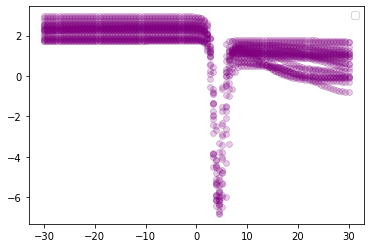

In [10]:
x = np.linspace(-30, 30, 100)
y = np.linspace(3, 3, 100)
newxy = np.concatenate((np.transpose([x]), np.transpose([y])), axis = 1)
newxy = torch.tensor(newxy, dtype = torch.float32)
newxy = torch.reshape(newxy,(100,2))

i = 0
while i<20:
    z = Reward(newxy)
    Z9 = torch.tensor(z, requires_grad = False).numpy()
    plt.scatter(x, Z9, color = 'purple', alpha = 0.2)
    i = i + 1

plt.legend()
plt.show()

In [11]:
Action_array = local_policy.fit()

In [12]:
Action_array

tensor([[[0.3978]],

        [[0.9731]],

        [[0.8117]],

        [[1.0367]]], grad_fn=<CopySlices>)